In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier
from scipy.signal import periodogram
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

In [27]:
# matplotlib defaults
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 5),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="#069AF3",          
    style=".-",               
    markeredgecolor="#FFA500", 
    markerfacecolor="#8B0000", 
    legend=True              
)

C:\Users\amaur\AppData\Local\Temp\ipykernel_24004\650705707.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Import

In [28]:
data_dir = Path('./data')

y_time = pd.read_csv(data_dir / 'Consommation_Metropole_du_Grand_Paris.csv', sep=';', index_col='Date')
METROPOLE = y_time.columns[0]
y_time

,Métropole du Grand Paris
Date,
2021-01-01 00:00,5135.0
2021-01-01 00:15,5072.0
2021-01-01 00:30,4982.0
2021-01-01 00:45,4903.0
2021-01-01 01:00,4830.0
...,...
2024-09-01 22:45,3414.0
2024-09-01 23:00,3361.0
2024-09-01 23:15,3373.0


In [29]:
y_time.index = pd.to_datetime(y_time.index)
y_time.sort_index(inplace=True)
y_time.index = y_time.index.to_period('15min')
y_time.index

y_time_serie = y_time.squeeze()

Une série temporelle est généralement modèlisée par les composantes suivantes : 
- **Tendance** : représente le mouvement global de la série temporelle sur une longue période. C'est une direction générale à la hausse ou à la baisse qui reflète un changement à long terme dans les données.

- **Saisonnalité** : désigne les fluctuations régulières et prévisibles qui se répètent à des intervalles de temps fixes, comme des jours, des mois ou des années.

- **Résidu ou bruit** : représente la composante aléatoire ou les variations imprévisibles des données.

On analysera également la **dynamique autorégressive** de notre série temporelle

## Tendance

In [30]:
def Trend_n(y_time, ORDER, forecast='2024-12-31', display_step=1):
    """
    Cette fonction modélise une tendance d'ordre n (linéaire, quadratique, etc.) sur une série temporelle 
    et produit des prévisions futures. Elle compare cette tendance un modèle d'ordre 1.

    Paramètres :
    - y_time : pd.Series, la série temporelle sur laquelle modéliser la tendance.
    - ORDER : int, ordre de la tendance (1 pour linéaire, 2 pour quadratique, etc.).
    - forecast : str, la date de fin de la prévision (par défaut : '2024-12-31').
    - display_step : int, le pas pour l'affichage des points réels sur le graphique.

    Retourne :
    - X_time_n : DataFrame, les variables explicatives de la tendance d'ordre n.
    - y_time : pd.Series, la série temporelle d'origine utilisée pour l'ajustement.
    """
    
    # Définir les bornes de la série temporelle (début et fin) et en extraire les index
    start, end = y_time.index[0], y_time.index[-1]
    index = y_time.index
    
    # Calculer le nombre d'étapes pour la prévision en fonction de la fréquence et de la date de fin
    n_step_forecast = len(pd.date_range(start=str(end), end=forecast, freq=y_time.index.freq))
    
    # Suppression des niveaux inutiles si y_time est un DataFrame multi-indexé
    y_time = y_time.squeeze()

    # Processus déterministe d'ordre 1 (modèle de tendance linéaire)
    dp_1 = DeterministicProcess(
        index=index,
        constant=True,  # Inclure une constante (biais) dans le modèle
        order=1,        # Modèle d'ordre 1 (linéaire)
        drop=True       # Supprimer les termes linéairement dépendants 
    )

    # Processus déterministe d'ordre n (modèle de tendance plus complexe)
    dp_n = DeterministicProcess(
        index=index,
        constant=True,  # Inclure une constante
        order=ORDER,    # Utiliser l'ordre défini par l'utilisateur (ex : quadratique, cubique, etc.)
        drop=False      # Ne pas supprimer les colonnes (garder toutes les variables pour le modèle d'ordre n)
    )

    # Génération des variables explicatives pour l'ajustement (in-sample) et la prévision (out-of-sample)
    X_time_1 = dp_1.in_sample()                  # Variables explicatives pour le modèle d'ordre 1 (in-sample)
    X_time_1_test = dp_1.out_of_sample(steps=n_step_forecast)  # Variables pour la prévision (out-of-sample)
    X_time_n = dp_n.in_sample()                  # Variables explicatives pour le modèle d'ordre n (in-sample)
    X_time_n_test = dp_n.out_of_sample(steps=n_step_forecast)  # Variables pour la prévision (out-of-sample)

    # Ajustement du modèle de régression linéaire pour l'ordre 1
    model_1 = LinearRegression(fit_intercept=False).fit(X_time_1, y_time)
    # Ajustement du modèle de régression linéaire pour l'ordre n
    model_n = LinearRegression(fit_intercept=False).fit(X_time_n, y_time)

    # Prédictions sur la période d'entraînement (in-sample) pour le modèle d'ordre 1
    y_order_1 = pd.Series(model_1.predict(X_time_1), index=X_time_1.index)
    # Prédictions sur la période de prévision (out-of-sample) pour le modèle d'ordre 1
    y_order_1_fore = pd.Series(model_1.predict(X_time_1_test), index=X_time_1_test.index)

    # Prédictions sur la période d'entraînement (in-sample) pour le modèle d'ordre n
    y_order_n = pd.Series(model_n.predict(X_time_n), index=X_time_n.index)
    # Prédictions sur la période de prévision (out-of-sample) pour le modèle d'ordre n
    y_order_n_fore = pd.Series(model_n.predict(X_time_n_test), index=X_time_n_test.index)

    # Création du graphique pour visualiser la tendance
    ax = y_time.loc[::display_step].plot(alpha=0.6)  # Affichage des points réels avec transparence (display_step)
    
    # Ajout de la courbe de tendance ajustée pour le modèle d'ordre 1
    ax = y_order_1.plot(ax=ax, label="Order_1_fit", color="C4")
    # Ajout des prévisions pour le modèle d'ordre 1
    ax = y_order_1_fore.plot(ax=ax, label="Order_1_forecast", color="C2", linewidth=3)
    
    # Ajout de la courbe de tendance ajustée pour le modèle d'ordre n
    ax = y_order_n.plot(ax=ax, label=f"Order_{ORDER}_fit")
    # Ajout des prévisions pour le modèle d'ordre n
    ax = y_order_n_fore.plot(ax=ax, label=f"Order_{ORDER}_forecast", color="C3", linewidth=3)

    # Titre du graphique
    ax.set_title(f"Puissance électrique en MegaWatts du {start} au {end}")
    ax.legend()  # Affichage de la légende

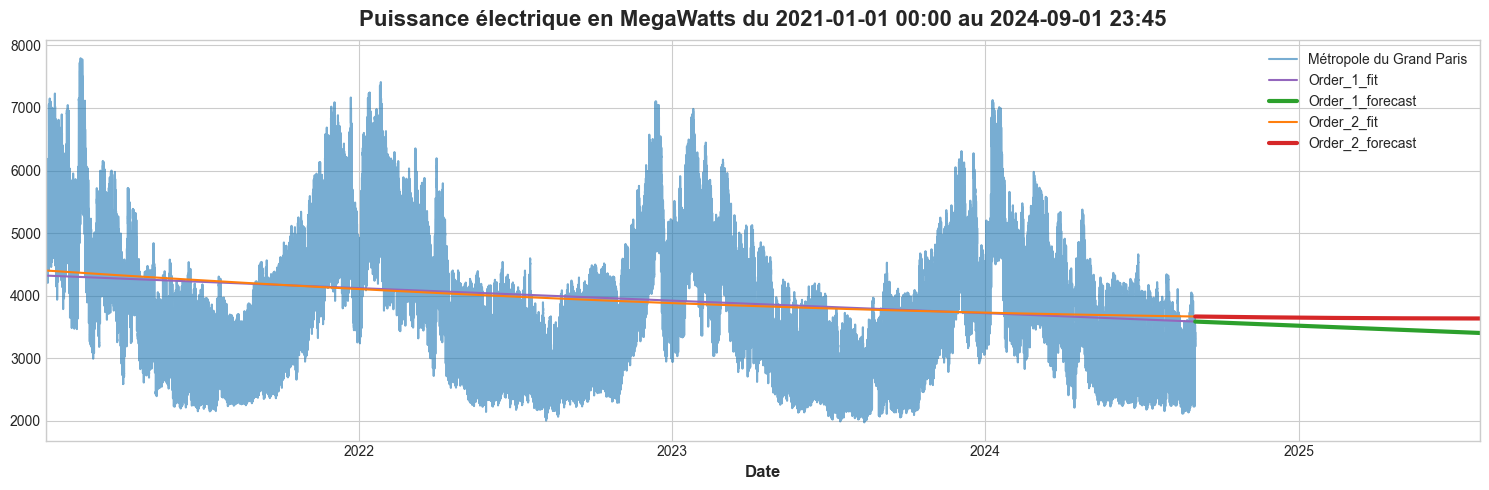

In [31]:
Trend_n(y_time, ORDER=2, forecast='2025-07-31')

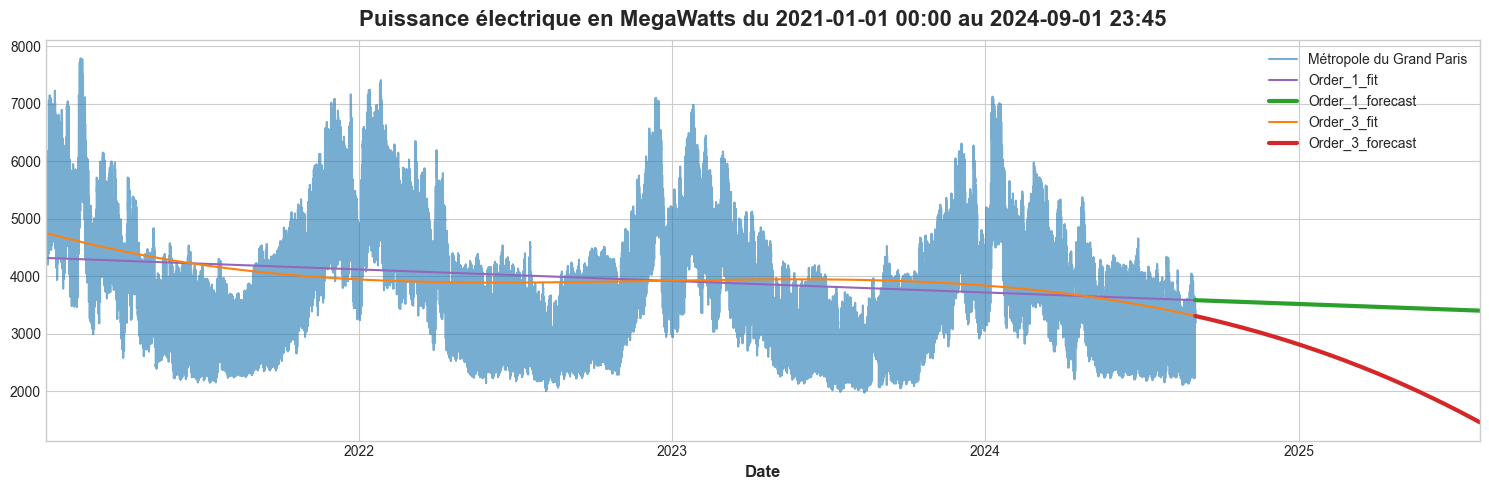

In [14]:
Trend_n(y_time, ORDER=3, forecast='2025-07-31')

On retient un modèle d'ordre 1, soit un modèle linéaire, pour représenter la tendance.

Voici à quoi correspondent nos features pour un modèle linéaire :

In [18]:
index = y_time.index

dp = DeterministicProcess(
    index=index,
    constant=True,  # Inclure une constante (biais) dans le modèle
    order=1,        # Modèle d'ordre 1 (linéaire)
    drop=True       # Supprimer les termes linéairement dépendants 
)

X_modele_lineaire = dp.in_sample()  
X_modele_lineaire

,const,trend
Date,,
2021-01-01 00:00,1.0,1.0
2021-01-01 00:15,1.0,2.0
2021-01-01 00:30,1.0,3.0
2021-01-01 00:45,1.0,4.0
2021-01-01 01:00,1.0,5.0
...,...,...
2024-09-01 22:45,1.0,128636.0
2024-09-01 23:00,1.0,128637.0
2024-09-01 23:15,1.0,128638.0


## Saisonnalité

In [33]:
def plot_periodogram(ts, detrend='linear', ax=None):
    ts = ts.squeeze()
    fs = pd.Timedelta("1D") / pd.Timedelta("15min")  # 96 points par jour (toutes les 15 min)

    # Calcul du périodogramme
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,  # fréquence d'échantillonnage en points par jour
        detrend=detrend,
        window="boxcar",
        scaling='spectrum'
    )
    if ax is None:
        _, ax = plt.subplots()   
        
    # Tracer le périodogramme
    ax.step(frequencies, spectrum)
    ax.set_xscale("log")
    # Repères des périodes (en jours)
    xticks = [1 / 365, 1 / 182.5, 1 / 91.25, 1 / 60, 1 / 30.42, 1 / 14, 1 / 7, 1 / 3.5, 1 / 1, 1 / (1/2),  1 / (1/24)]
    xticklabels = [
        "Annuel", "Semi-annuel", "Trimestriel", "Bimensuel", "Mensuel",
        "Bihebdomadaire", "Hebdomadaire", "Semi-Hebdomadaire", "Quotidien", "Semi-Quotidien", "Horaire"
    ]

    ax.tick_params(axis='x', width=1.5, color='r', length=10, direction='inout')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=30)
    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogramme")
    
    plt.show()
    return ax

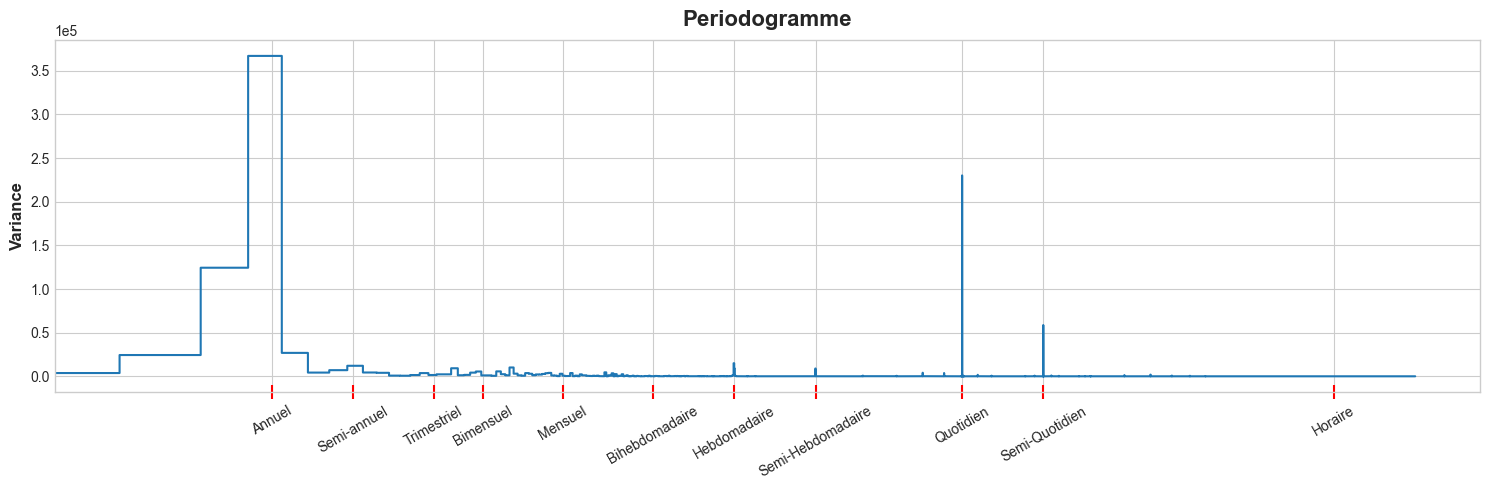

<Axes: title={'center': 'Periodogramme'}, ylabel='Variance'>

In [34]:
plot_periodogram(y_time)

### Le Périodogramme : Analyse du Spectre de Fréquence

Le périodogramme est un outil permettant d'analyser le spectre en fréquence d'une série temporelle dont la tendance linéaire a été préalablement supprimée.  
L'observation du périodogramme révèle deux pics importants, indiquant des cycles récurrents spécifiques dans notre série de données :

- **Un pic annuel** : reflète une saisonnalité annuelle dans la consommation d'électricité.
- **Un pic quotidien** : montre une variation quotidienne marquée.

Ces pics suggèrent que la consommation d'électricité présente deux composantes saisonnières principales : une composante annuelle et une composante quotidienne, correspondant respectivement aux variations saisonnières sur l'année et aux variations journalières.


In [35]:
puissance = 'Puissance éléctrique'

def seasonal_plot(X, period, freq, y=puissance, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Graphique saisonnier par {period}")
    plt.show()
    return ax

### Saisonnalité : composante annuelle

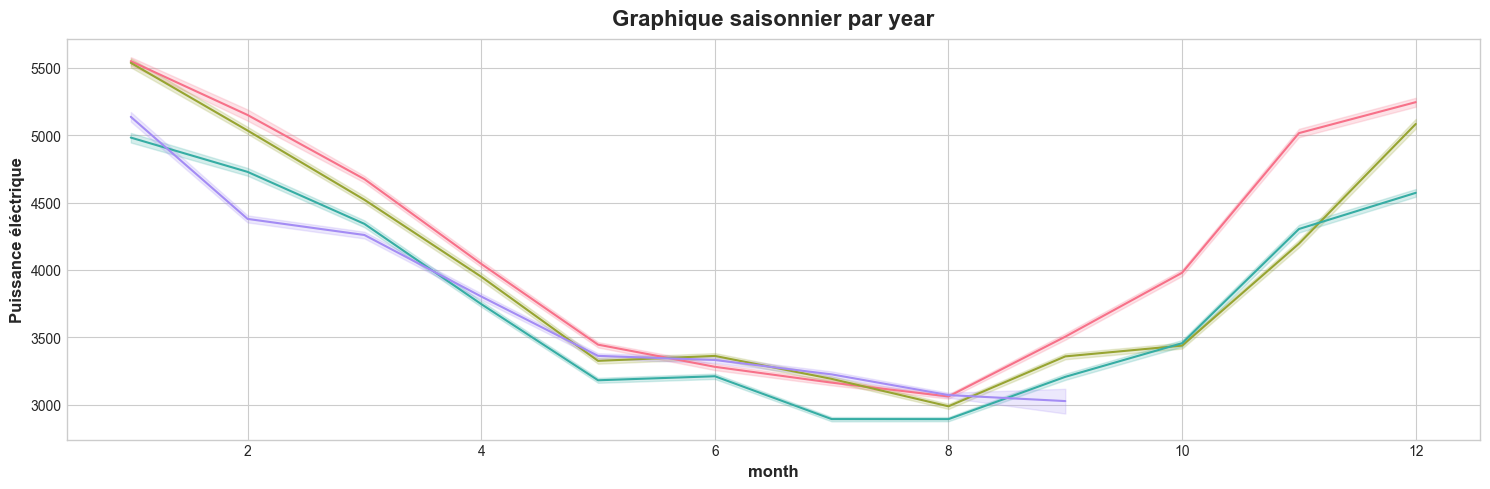

<Axes: title={'center': 'Graphique saisonnier par year'}, xlabel='month', ylabel='Puissance éléctrique'>

In [37]:
#### Saisonnalité : Periode annuelle ####
y_season_year = y_time_serie.copy()
y_season_year = y_season_year.to_frame(name=puissance)
y_season_year["month"] = y_season_year.index.month  
y_season_year["year"] = y_season_year.index.year  

seasonal_plot(y_season_year, period='year', freq='month')

### Saisonnalité : composante quotidienne

Affichage pour l'année 2024

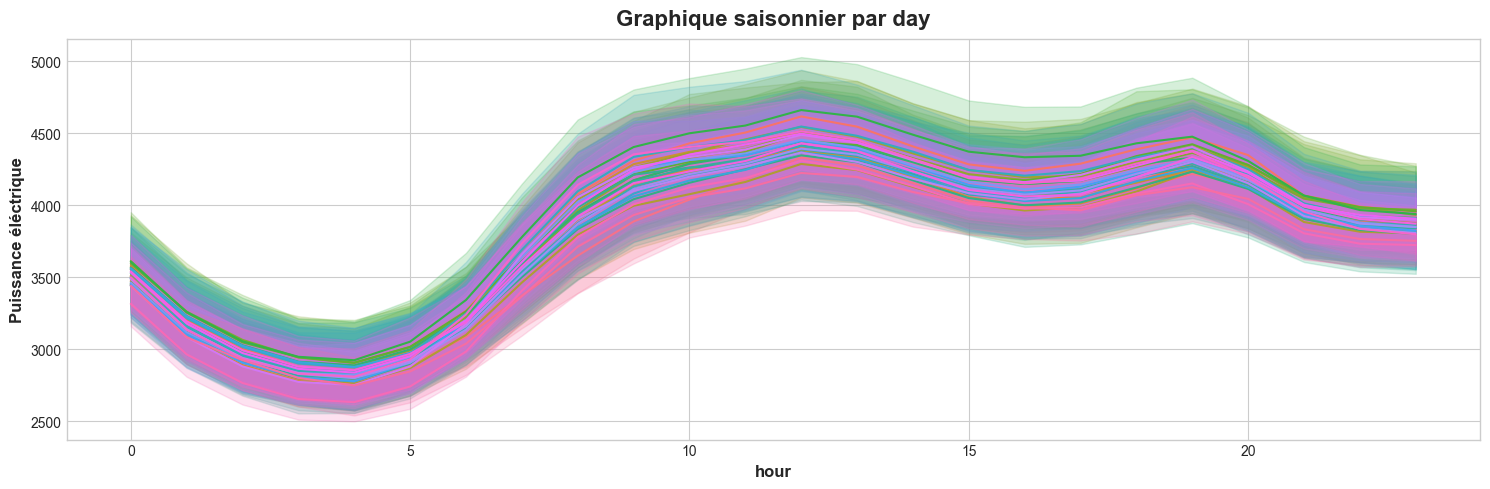

<Axes: title={'center': 'Graphique saisonnier par day'}, xlabel='hour', ylabel='Puissance éléctrique'>

In [38]:
y_season_day = y_time_serie.copy()
y_season_day = y_season_day.to_frame(name=puissance)
y_season_day["hour"] = y_season_day.index.hour 
y_season_day["day"] = y_season_day.index.day
#### Affichage pour l'année 2024 ####
y_season_day_2024 = y_season_day[y_season_day.index.year == 2024]
seasonal_plot(y_season_day_2024, period='day', freq='hour')

Affichage pour l'année 2023

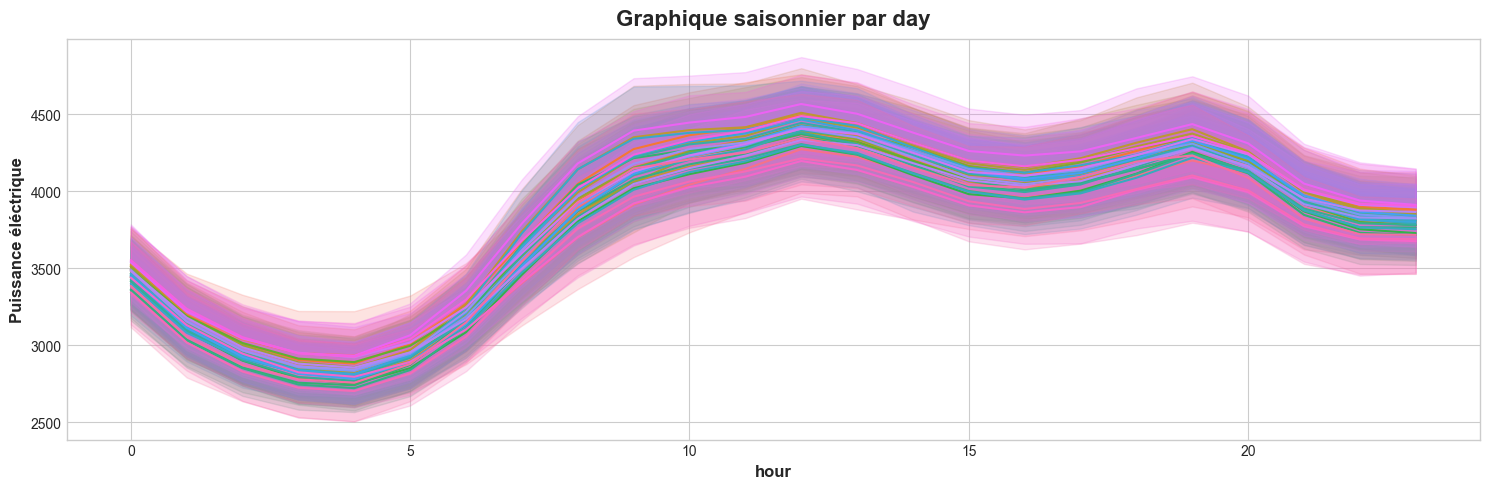

<Axes: title={'center': 'Graphique saisonnier par day'}, xlabel='hour', ylabel='Puissance éléctrique'>

In [39]:
#### Affichage pour l'année 2023 ####
y_season_day_2024 = y_season_day[y_season_day.index.year == 2023]
seasonal_plot(y_season_day_2024, period='day', freq='hour')

### Modèle d'Ordre 1 et Composantes Saisonnières

Nous allons retenir un **modèle d'ordre 1**, c'est-à-dire un **modèle linéaire** pour représenter la tendance. En parallèle, nous utiliserons des **coefficients de Fourier** pour modéliser les composantes saisonnières, à la fois annuelle et quotidienne.

Voici à quoi correspondent nos **features** pour ce modèle :


In [40]:
index = y_time.index

fourier_Annuel = CalendarFourier(freq="A", order=3) 
fourier_Daily = CalendarFourier(freq="D", order=3)               
dp_fourier = DeterministicProcess(
            index = index,
            constant=True,             
            order=1,                                                 
            additional_terms=[fourier_Annuel, fourier_Daily],     
            drop=True
)

X_modele_lineaire_fourier = dp_fourier.in_sample()
X_modele_lineaire_fourier

,const,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)","sin(3,freq=D)","cos(3,freq=D)"
Date,,,,,,,,,,,,,,
2021-01-01 00:00,1.0,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2021-01-01 00:15,1.0,2.0,0.000179,1.000000,0.000359,1.000000,0.000538,1.000000,0.065403,0.997859,0.130526,0.991445,0.195090,0.980785
2021-01-01 00:30,1.0,3.0,0.000359,1.000000,0.000717,1.000000,0.001076,0.999999,0.130526,0.991445,0.258819,0.965926,0.382683,0.923880
2021-01-01 00:45,1.0,4.0,0.000538,1.000000,0.001076,0.999999,0.001614,0.999999,0.195090,0.980785,0.382683,0.923880,0.555570,0.831470
2021-01-01 01:00,1.0,5.0,0.000717,1.000000,0.001435,0.999999,0.002152,0.999998,0.258819,0.965926,0.500000,0.866025,0.707107,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01 22:45,1.0,128636.0,-0.874047,-0.485842,0.849297,-0.527916,0.048800,0.998809,-0.321439,0.946930,-0.608761,0.793353,-0.831470,0.555570
2024-09-01 23:00,1.0,128637.0,-0.874134,-0.485685,0.849108,-0.528220,0.049336,0.998782,-0.258819,0.965926,-0.500000,0.866025,-0.707107,0.707107
2024-09-01 23:15,1.0,128638.0,-0.874221,-0.485529,0.848919,-0.528523,0.049871,0.998756,-0.195090,0.980785,-0.382683,0.923880,-0.555570,0.831470


## Dynamique autorégressive

In [41]:
def lagplot(serie, n_lag, ax=None, regModel=None):
    """
    Fonction pour tracer un lagplot (graphe de retard) entre une série et une version décalée (lag) d'elle-même,
    et pour ajuster une régression linéaire entre ces deux séries.

    Paramètres :
    - serie : pd.Series, la série temporelle d'origine.
    - n_lag : int, le nombre de décalages (lags) à appliquer à la série.
    - ax : matplotlib axis, optionnel, l'axe sur lequel tracer le graphique. Si None, un nouvel axe sera créé.
    - regModel : modèle de régression linéaire, optionnel. Par défaut, un modèle LinearRegression() est utilisé.

    Retour :
    - ax : l'axe contenant le lagplot et la ligne de régression ajustée.
    """

    # Si aucun axe (ax) n'est fourni, créer un nouvel axe.
    if ax is None:
        fig, ax = plt.subplots()

    # Si aucun modèle de régression n'est fourni, utiliser LinearRegression() par défaut.
    if regModel is None:
        regModel = LinearRegression()

    # Décalage de la série de n_lag périodes, et suppression des valeurs NaN résultantes.
    lag_serie = serie.shift(n_lag).dropna(axis=0)

    # Aligner la série originale et la série décalée pour s'assurer qu'elles ont le même index.
    serie, lag_serie = serie.align(lag_serie, join='inner', axis=0)

    # Calcul de la corrélation entre la série originale et la série décalée.
    corr = serie.corr(lag_serie)

    # Ajustement du modèle de régression entre la série originale (X) et la série décalée (y).
    y_pred = regModel.fit(serie.to_frame(), lag_serie).predict(serie.to_frame())

    # Tracé d'un scatter plot (nuage de points) pour visualiser la relation entre la série originale et la décalée.
    ax.scatter(x=serie, y=lag_serie)

    # Tracé de la ligne de régression ajustée sur le scatter plot.
    ax.plot(serie, y_pred, color='C3')

    # Ajout d'un titre incluant la corrélation entre les deux séries.
    ax.set_title(f"Lag {n_lag} Corr = {round(corr, 2)}")

    # Étiquetage des axes X et Y.
    ax.set_xlabel('Série')
    ax.set_ylabel('Série décalée')

    # Retourner l'axe contenant le graphique.
    return ax

In [42]:
def plot_lags(serie, lagtoplot):
    """
    Fonction pour tracer plusieurs lag plots (graphes de retard) sur une seule figure, afin de visualiser la relation
    entre une série temporelle et plusieurs versions décalées (lags) d'elle-même.

    Paramètres :
    - serie : pd.Series, la série temporelle d'origine.
    - lagtoplot : int, le nombre de décalages (lags) à tracer. Chaque lag représente un pas dans le temps par rapport à la série d'origine.

    Retour :
    - fig : la figure matplotlib contenant les différents lag plots.
    """

    # Calcul du nombre de lignes dans la figure.
    # Si le nombre total de lag plots à afficher n'est pas divisible par 4, ajouter une ligne supplémentaire.
    if (lagtoplot % 4) > 0:
        nrows = int(lagtoplot // 4) + 1  # Diviser par 4 pour avoir un arrangement en 4 colonnes par ligne.
    else:
        nrows = int(lagtoplot // 4)  # Si le nombre de lag plots est divisible par 4, pas besoin de ligne supplémentaire.

    # Création d'une figure avec plusieurs sous-graphiques (subplots) organisés en nrows lignes et 4 colonnes.
    # Le paramètre figsize ajuste la taille globale de la figure.
    fig, list_axes = plt.subplots(nrows=nrows, ncols=4, figsize=(4 * 3, nrows * 3 + 0.5), sharex=True, sharey=True)

    # Redimensionne l'array des axes pour être à plat (list_axes devient une liste d'axes).
    list_axes.resize(list_axes.size,)

    # Modèle de régression linéaire utilisé pour ajuster une ligne sur chaque lag plot.
    model = LinearRegression()

    # Boucle sur chaque sous-graphe (lag plot).
    for lag, ax in enumerate(list_axes):
        if lag < lagtoplot:  # On ne trace que jusqu'à lagtoplot.
            # Appel de la fonction lagplot pour tracer le graphe du lag actuel.
            lagplot(serie, n_lag=lag+1, ax=ax)
        else:
            # Si on a plus de sous-graphiques que de lags à tracer, on désactive les axes restants.
            ax.axis('off')

    # Affichage de la figure complète avec tous les lag plots.
    plt.show()
    
    # Retourne la figure contenant tous les lag plots.
    return fig

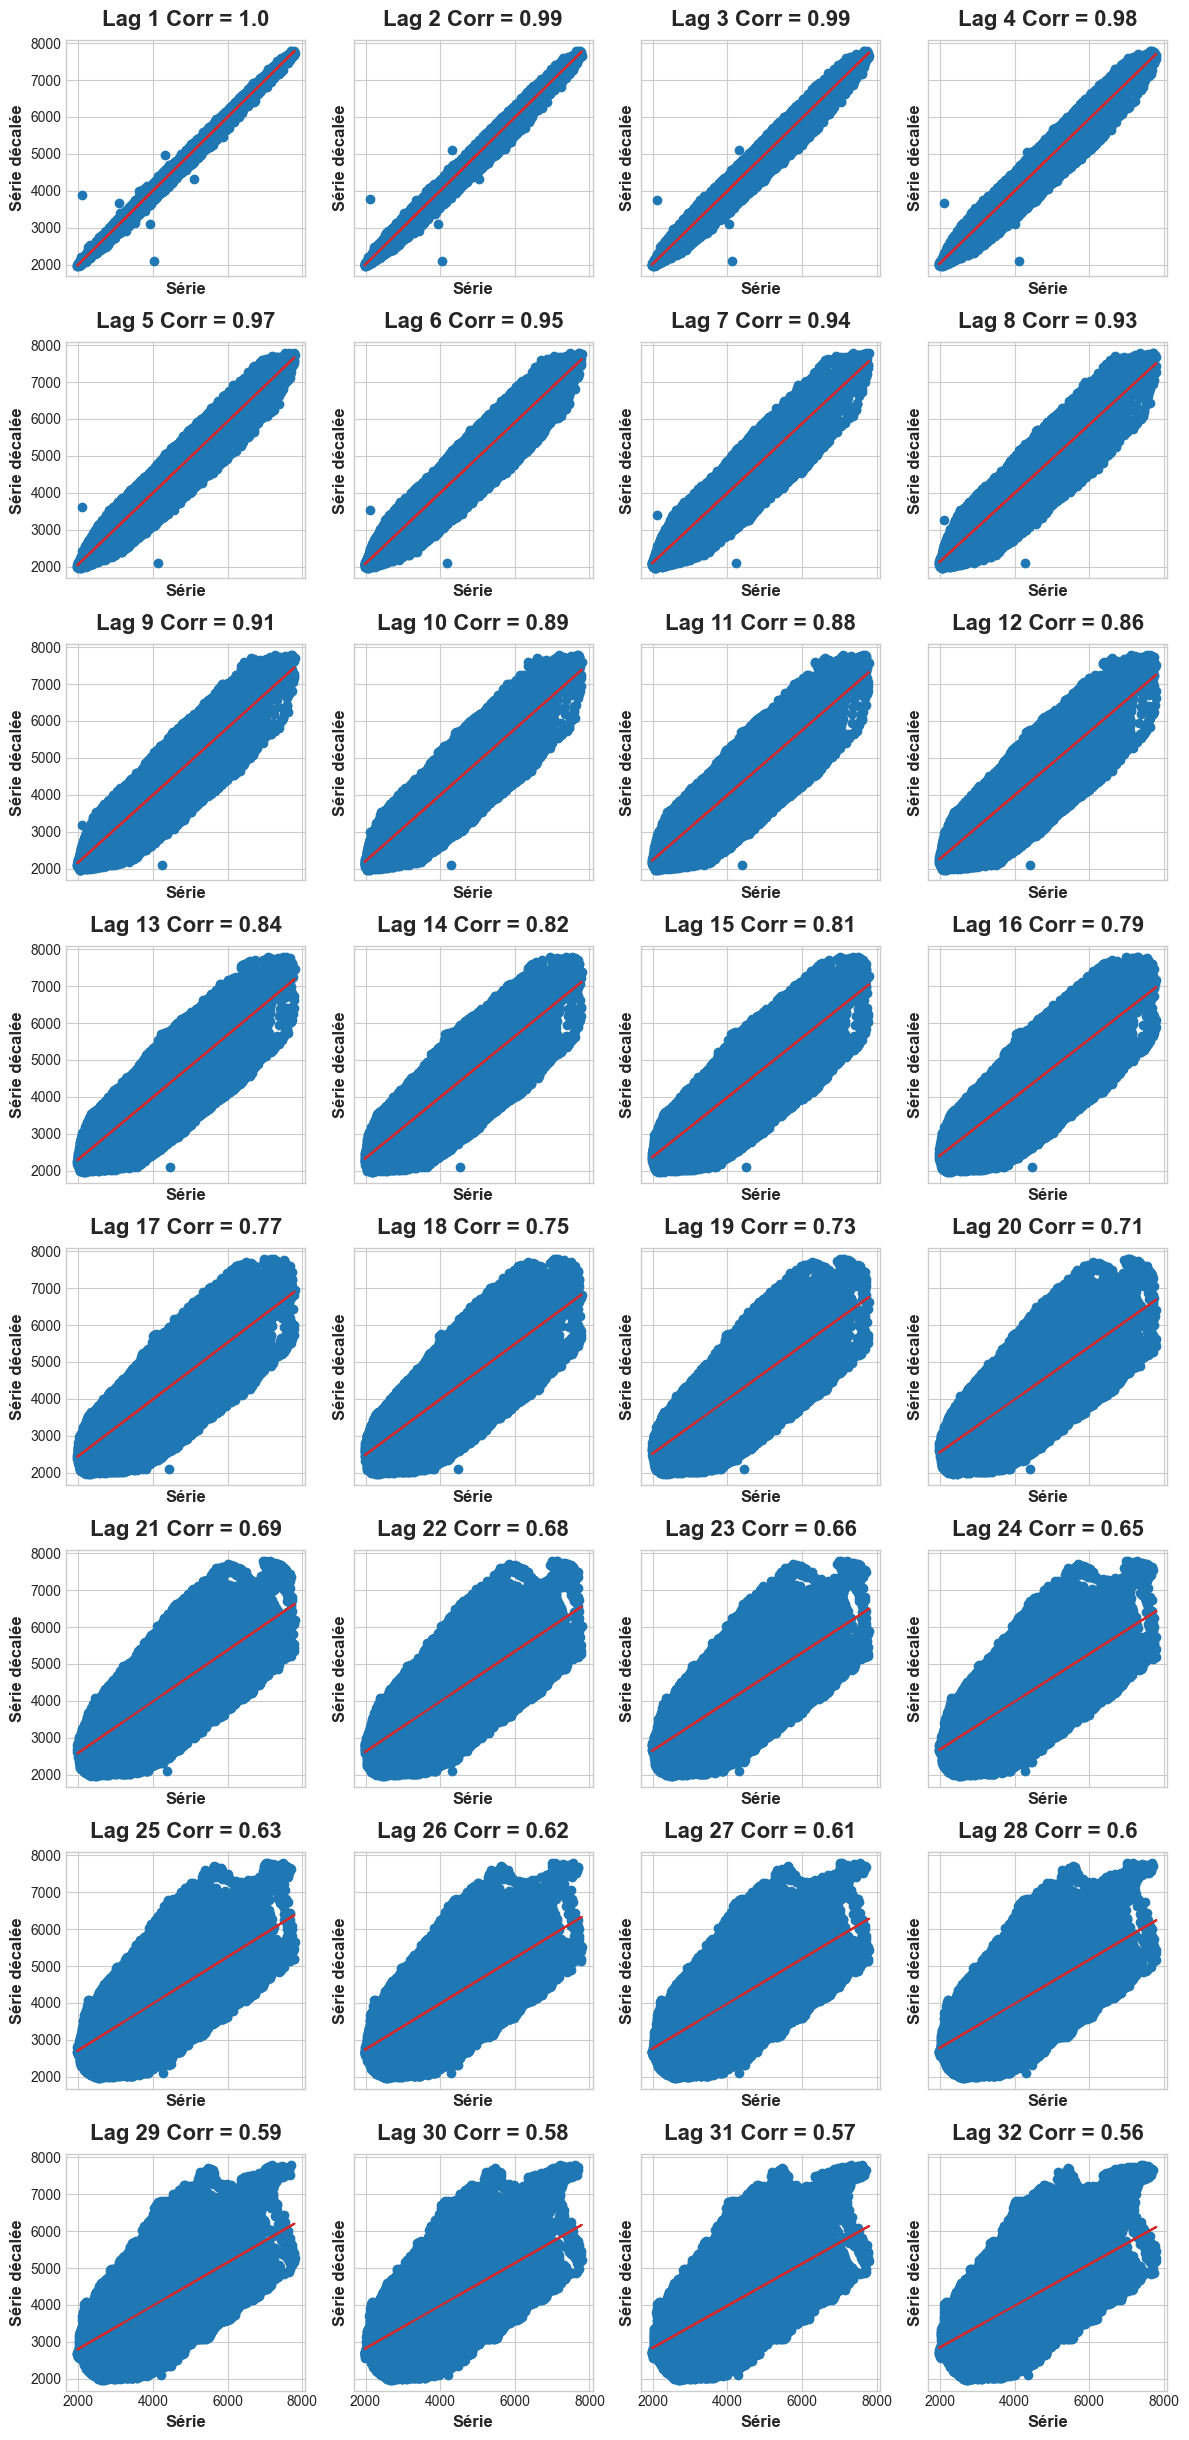

In [44]:
_ = plot_lags(y_time_serie, 32)

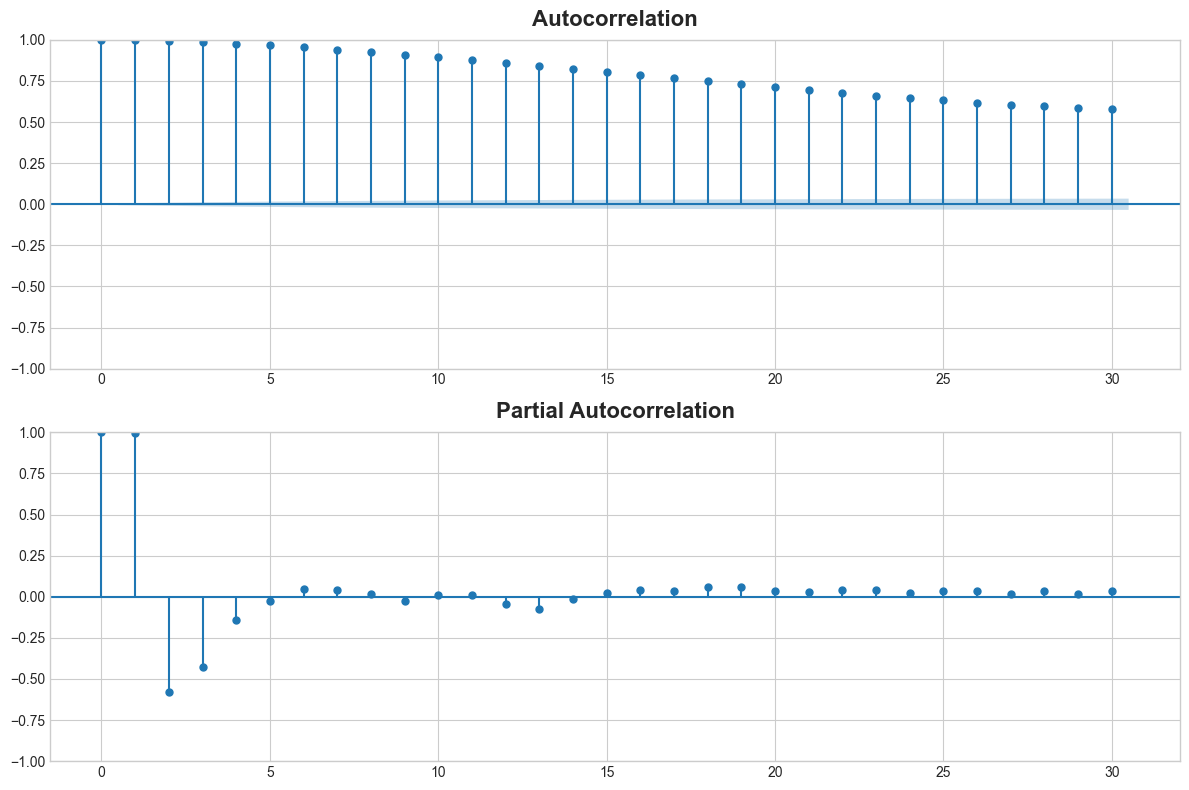

In [45]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_time, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_time, method='ywm', lags=30, ax=ax2) # lag = 4

### Corrélation de la Série avec ses Termes Précédents

La série semble être corrélée à ses termes précédents :

- **Premier Graphique** : On observe une **corrélation significative** pour les premiers lags, qui décroît lentement.

- **Deuxième Graphique** : On retrouve cette lente décroissance sur le graphe d'autocorrélation, ce qui traduit une **dynamique autorégressive**. Le graphique d'autocorrélation partielle nous renseigne sur la corrélation entre la série et sa version décalée, sans les effets linéaires des termes précédents. Cela indique le nombre de lags à utiliser : ici, **4 lags** pour un modèle autorégressif.


In [46]:
def make_lags(ts_to_copy, lags):
    ts = ts_to_copy.copy()
    return pd.concat( {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1) },
        axis=1)

lags = make_lags(y_time, lags=4)
X_modele_lineaire_fourier_lag = pd.concat((X_modele_lineaire_fourier , lags), axis=1)

X_modele_lineaire_fourier_lag.head()

,const,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)","sin(3,freq=D)","cos(3,freq=D)","(y_lag_1, Métropole du Grand Paris)","(y_lag_2, Métropole du Grand Paris)","(y_lag_3, Métropole du Grand Paris)","(y_lag_4, Métropole du Grand Paris)"
Date,,,,,,,,,,,,,,,,,,
2021-01-01 00:00,1.0,1.0,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN
2021-01-01 00:15,1.0,2.0,0.000179,1.0,0.000359,1.000000,0.000538,1.000000,0.065403,0.997859,0.130526,0.991445,0.195090,0.980785,5135.0,NaN,NaN,NaN
2021-01-01 00:30,1.0,3.0,0.000359,1.0,0.000717,1.000000,0.001076,0.999999,0.130526,0.991445,0.258819,0.965926,0.382683,0.923880,5072.0,5135.0,NaN,NaN
2021-01-01 00:45,1.0,4.0,0.000538,1.0,0.001076,0.999999,0.001614,0.999999,0.195090,0.980785,0.382683,0.923880,0.555570,0.831470,4982.0,5072.0,5135.0,NaN
2021-01-01 01:00,1.0,5.0,0.000717,1.0,0.001435,0.999999,0.002152,0.999998,0.258819,0.965926,0.500000,0.866025,0.707107,0.707107,4903.0,4982.0,5072.0,5135.0
